<h1 align=center> 📹 End-to-End Video Emotion Recognition using MediaPipe and a CNN-LSTM Architecture 🤖 </h1>

This project details a complete system for recognizing human emotions from short video clips, designed for a journaling application 📓 that uses video as a cover for entries. 

A key innovation of this notebook is its unique data processing pipeline. It starts with the AFEW-VA dataset 📊, which only provides continuous `valence` and `arousal` scores. This pipeline transforms those scores into discrete emotion labels by:
1.  Averaging the scores per video.
2.  Applying K-Means clustering 🧩 to group the data.
3.  Performing manual curation ✍️ to ensure high-quality labels.

The system then uses MediaPipe 🌐 to extract 3D face mesh vectors from video frames and feeds sequences of this data into a hybrid **CNN-LSTM model** 🧠 to classify the final emotion. 😊

The resulting five emotion labels used for training are: 
- Anger
- Happy 
- Shock
- Neutral
- Sad

## 💡 Use Case Possibilities

While this model was initially designed for a journaling app, the core technology can be adapted for a wide range of powerful applications:

* **📓 Enhanced Digital Journaling & Mental Wellness:** The primary use case. The app can track mood patterns over time, helping users gain insight into their emotional wellbeing. It could suggest activities or resources based on detected emotional trends.

* **🧠 User Experience (UX) Research:** Companies can analyze user reactions to new software, websites, or products in real-time. This provides authentic, unbiased feedback on whether a feature is delightful, confusing, or frustrating.

* **📚 Adaptive E-Learning Platforms:** An online learning system could gauge a student's emotional state. If the system detects confusion or frustration, it could automatically offer hints, supplementary materials, or a different teaching approach.

* **🎬 Audience Reaction Analysis:** Media companies could use this to analyze audience reactions during movie screenings or trailer tests to gauge emotional engagement with the content.

* **🚗 Driver Monitoring Systems:** In-car cameras could use the model to detect driver states like drowsiness, distraction, or road rage, triggering safety alerts to prevent accidents.

<video width="600" controls>
  <source src="./Assets/journaling_illustration.mp4" type="video/mp4">
</video>

*The illustration is generated by AI

### 📈 Key Results
* The final CNN-LSTM model achieved a **validation accuracy of 79.52%** on the curated test set.
* Successfully demonstrated a full pipeline from raw data with continuous labels to a functioning discrete emotion classifier.

### 📊 About the AFEW-VA Dataset

*Dataset Source:
```
J. Kossaifi, G. Tzimiropoulos, S. Todorovic, and M. Pantic, "AFEW-VA database for valence and arousal estimation in-the-wild," Image and Vision Computing, vol. 65, pp. 23-36, 2017, doi: 10.1016/j.imavis.2017.02.001.
```

![AFEW-VA Valence-Arousal Distribution](./Assets/afew-va_example.png)

#### **Key Characteristics**
* **🎬 Content**: 600 video clips from feature films, selected for their challenging nature.
* **🏞️ Environment**: "In-the-wild" conditions with complex backgrounds, lighting, and head poses.
* **🏷️ Annotations**: Provides two types of labels for each frame:
    * `valence` (positive/negative) and `arousal` (calm/excited) scores on a -10 to 10 scale.
    * The locations of 68 facial landmarks.
* **✍️ Annotation Method**: A custom-built online tool was used for precise per-frame labeling by two collaborating, FACS-certified experts.

### ⚙️ 1. Preparing the Dataset

The following code handles the initial data setup. We import the required libraries, download the AFEW-VA dataset from Kaggle Hub, and then use a parallelized script to efficiently copy the files into our local `./Dataset` folder for the project.

In [1]:
import kagglehub
import os
import shutil
import concurrent.futures
from functools import partial
from tqdm import tqdm

In [2]:
def copy_item(item, source_dir, dest_dir):
    """
    Helper function to copy a single item from source to destination
    """
    src_path = os.path.join(source_dir, item)
    dst_path = os.path.join(dest_dir, item)
    
    # If the destination path exists, replace it
    if os.path.exists(dst_path):
        if os.path.isdir(dst_path):
            shutil.rmtree(dst_path)
        else:
            os.remove(dst_path)
            
    if os.path.isdir(src_path):
        shutil.copytree(src_path, dst_path)
    else:
        shutil.copy2(src_path, dst_path)

destination_dir = './Dataset/AFEW-VA'
os.makedirs(destination_dir, exist_ok=True)

# Download data from kaggle
cache_path = kagglehub.dataset_download("hoanguyensgu/afew-va")
source_dir = os.path.join(cache_path, "AFEW-VA")
items = os.listdir(source_dir)

# Prepare parallel copy task
copy_task = partial(copy_item, source_dir=source_dir, dest_dir=destination_dir)
num_workers = os.cpu_count() * 2

# Copy data in parallel
with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
    list(tqdm(executor.map(copy_task, items), total=len(items), desc='Copying Files'))

Copying Files: 100%|██████████| 601/601 [00:11<00:00, 51.31it/s]


## 🔬 2. Data Processing & Feature Extraction

![Feature Extraction Pipeline](./Assets/feature_extraction.png)

This is the core data engineering section of the project. The goal here is to transform the raw AFEW-VA dataset into a structured, feature-rich format that is ready for training our deep learning model. This involves a multi-step pipeline:

1.  **🎬 Video Generation**: The initial dataset provides videos as sequences of images. The first step is to convert these image sequences into standard `.mp4` video files for easier processing.

2.  **🏷️ Emotion Label Generation**: Since the dataset provides continuous `valence` and `arousal` scores instead of discrete emotions, we generate our own labels. This is done by:
    * Averaging the valence and arousal scores for each video.
    * Using **K-Means clustering** on these averages to group videos into distinct emotional categories.
    * Assigning human-readable labels (`Anger`, `Happy`, etc.) to these clusters.
    * Performing a final manual review and correction using an external CSV file to ensure label accuracy. The videos are then reorganized into folders named after their final emotion label.

3.  **🌐 Face Mesh Extraction with MediaPipe**: Each labeled video is processed frame-by-frame using Google's MediaPipe Face Mesh solution. This powerful tool extracts the 3D coordinates (x, y, z) for **468 distinct facial landmarks** for every face detected.

4.  **📜 CSV Export for Sequencing**: The extracted landmark data is exported into CSV files. To prepare the data for the CNN-LSTM model, the landmarks from each video are chunked into sequences of **15 frames**. Each resulting CSV file represents one of these 15-frame sequences, which will become a single input sample for our model.

**The entire pipeline is divided into three main stages**, each executed by the code cells below:

* 🎬 **Stage 1: Video Generation** - Converts the dataset's raw image sequences into standard `.mp4` video files.
* 🏷️ **Stage 2: Label Generation** - Creates discrete emotion labels (e.g., Happy, Sad) from the dataset's raw valence/arousal scores using K-Means clustering and manual review.
* 📜 **Stage 3: Feature Extraction** - Processes the labeled videos with MediaPipe to extract 3D facial landmarks and saves them as sequential 15-frame CSV files, preparing the data for the model.

In [3]:
import os
import glob
import json
import csv
import shutil

from concurrent.futures import ThreadPoolExecutor

import tqdm

import cv2
import numpy as np
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns

import mediapipe as mp

### 🎬 **Stage 1: Converting Image Sequences to MP4**

The first stage of the pipeline focuses on standardizing the data format. The original AFEW-VA dataset provides each video as a folder containing a sequence of PNG images. This code iterates through each of these folders, reads the sorted image sequence, and uses OpenCV to compile them into a single, standard `.mp4` video file. This process is parallelized using a thread pool to efficiently handle all 600 videos.

In [4]:
def create_video_from_images(image_folder, output_video_path, fps=30):
    """
    Create a video from a sequence of PNG images in a folder.
    """
    # List all images in a folder
    image_files = sorted(glob.glob(os.path.join(image_folder, '*.png')))

    first_frame = cv2.imread(image_files[0])
    height, width, layers = first_frame.shape
    frame_size = (width, height)

    # Video Writer with MP4V codec
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, frame_size)

    for image_file in image_files:
        frame = cv2.imread(image_file)
        video_writer.write(frame)

    video_writer.release()

In [5]:
def average_valence_arousal(base_folder):
    """
    Calculate each video and overall valence and arousal statistics.
    """
    per_file_average = {}

    overall_min_valence = float('inf')
    overall_max_valence = float('-inf')
    overall_min_arousal = float('inf')
    overall_max_arousal = float('-inf')

    for folder_name in sorted(os.listdir(base_folder)):
        folder_path = os.path.join(base_folder, folder_name)
        if os.path.isdir(folder_path):
            json_path = os.path.join(folder_path, f"{folder_name}.json")
            with open(json_path, 'r', encoding='utf-8') as file:
                data = json.load(file)

            frames = data['frames']

            valences = [frame_data['valence'] for frame_data in frames.values()]
            arousals = [frame_data['arousal'] for frame_data in frames.values()]

            min_valence, max_valence = min(valences), max(valences)
            avg_valence = sum(valences) / len(valences)
            
            min_arousal, max_arousal = min(arousals), max(arousals)
            avg_arousal = sum(arousals) / len(arousals)

            # Statistics for each video
            per_file_average[folder_name] = {
                "average_valence": avg_valence,
                "min_valence": min_valence,
                "max_valence": max_valence,
                "average_arousal": avg_arousal,
                "min_arousal": min_arousal,
                "max_arousal": max_arousal,
            }
            
            overall_min_valence = min(overall_min_valence, min_valence)
            overall_max_valence = max(overall_max_valence, max_valence)
            overall_min_arousal = min(overall_min_arousal, min_arousal)
            overall_max_arousal = max(overall_max_arousal, max_arousal)

        final_data = {
            "per_file_average": per_file_average,
            "overall_stats": {
                "overall_min_valence": overall_min_valence,
                "overall_max_valence": overall_max_valence,
                "overall_min_arousal": overall_min_arousal,
                "overall_max_arousal": overall_max_arousal,
            }
        }

    return final_data

In [6]:
base_folder = './Dataset/AFEW-VA'
video_output_folder = './Data/AFEW-VA/Video'
facemesh_output_folder = './Data/AFEW-VA/FaceMesh'

# Create output directories
os.makedirs(video_output_folder, exist_ok=True)
os.makedirs(facemesh_output_folder, exist_ok=True)

In [7]:
from concurrent.futures import ThreadPoolExecutor

def process_folder(folder_path):
    folder_name = os.path.basename(folder_path)
    output_video_file = os.path.join(video_output_folder, f'{folder_name}.mp4')
    if os.path.isdir(folder_path):
        create_video_from_images(folder_path, output_video_file, fps=30)

subfolders = sorted([f.path for f in os.scandir(base_folder)])

with ThreadPoolExecutor(max_workers=os.cpu_count() * 2) as executor:
    list(tqdm.tqdm(executor.map(process_folder, subfolders), total=len(subfolders), desc='Generating Video'))

Generating Video: 100%|██████████| 601/601 [00:35<00:00, 16.89it/s]


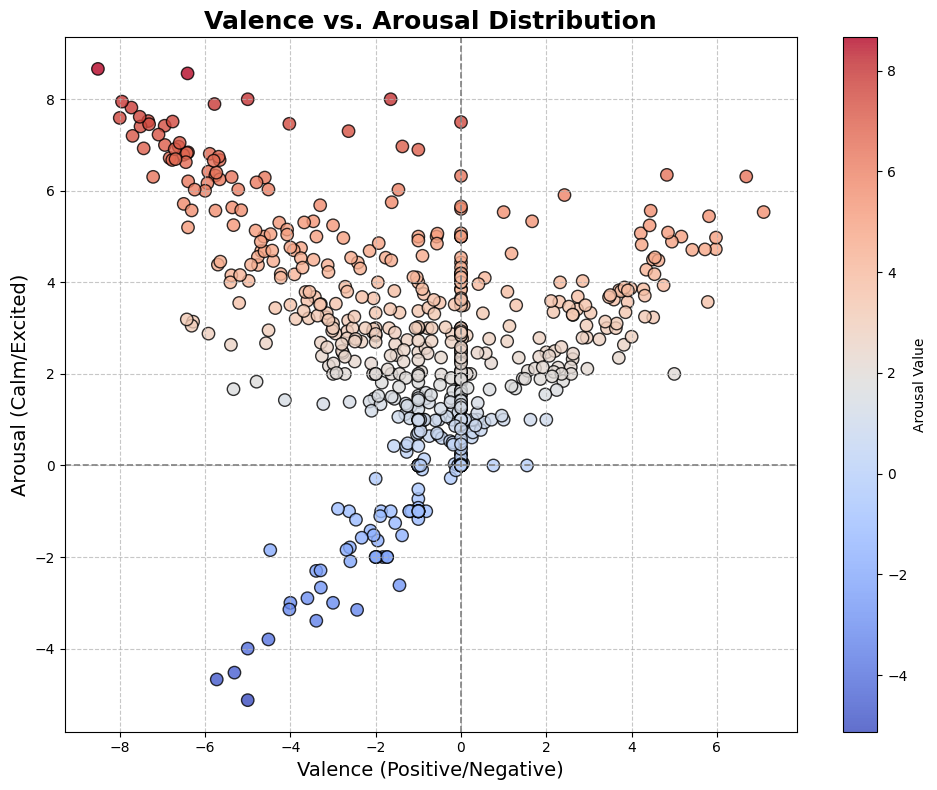

In [8]:
# Get average valence and arousal for each video
analysis_results = average_valence_arousal(base_folder)
per_file_data = analysis_results.get("per_file_average", {})

# Collect average valence and arousal from each video
avg_valences = [data['average_valence'] for data in per_file_data.values()]
avg_arousals = [data['average_arousal'] for data in per_file_data.values()]

# Plotting the distribution of valence and arousal
plt.figure(figsize=(10, 8))
plt.scatter(
    avg_valences, avg_arousals,
    alpha=0.8, edgecolors='k', s=80, c=avg_arousals, cmap='coolwarm'
)

plt.title('Valence vs. Arousal Distribution', fontsize=18, fontweight='bold')
plt.xlabel('Valence (Positive/Negative)', fontsize=14)
plt.ylabel('Arousal (Calm/Excited)', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(0, color='grey', lw=1.2, linestyle='--')
plt.axvline(0, color='grey', lw=1.2, linestyle='--')

plt.colorbar(label='Arousal Value')

plt.tight_layout()
plt.show()

#### 🔬 Analyzing the Valence-Arousal Space

This scatter plot visualizes the emotional landscape of the entire AFEW-VA dataset. Each point on the chart represents one of the 600 videos, positioned based on its average `valence` (the horizontal axis, representing negative to positive sentiment) and `arousal` (the vertical axis, representing calm to excited energy levels).

**Justification for Clustering**

The key insight from this plot is that the data points are not randomly scattered. Instead, they form a distinct V-shape structure, which is characteristic of emotional distributions. We can clearly see several natural groupings or "clouds" of data points:

* **Top-Left Quadrant**: A dense cluster with high arousal and negative valence, likely corresponding to emotions like **Anger** or **Fear**.
* **Top-Right Quadrant**: Another dense cluster with high arousal and positive valence, suggesting emotions like **Happy** or **Excited**.
* **Lower Regions**: A concentration of points with low arousal, which could represent **Sad** or **Neutral** states.

Because these visually separable groups exist, it provides a strong justification for using a clustering algorithm. The goal of **K-Means clustering** in the next step is to mathematically identify the centers of these natural groups. We can then assign a discrete emotion label (e.g., `Happy`, `Sad`) to each cluster, effectively transforming the continuous valence-arousal data into the distinct classes needed to train our classification model.

### 🏷️ **Stage 2: Emotion Label Generation via Clustering**

![Clustering Illustration](./Assets/clustering.png)

This stage addresses the core challenge of the AFEW-VA dataset: the absence of discrete emotion labels. The process to generate high-quality labels is as follows:
1.  **Aggregate Scores**: The continuous `valence` and `arousal` scores for every frame in a video are averaged into a single representative point.
2.  **Explore Clusters**: K-Means clustering is performed with various cluster counts (k=3 to 10) to find the most natural grouping of the data.
3.  **Assign Labels**: Based on visual inspection, **k=5** is chosen as the optimal number of clusters. These clusters are then mapped to the five emotion labels: `Anger`, `Happy`, `Shock`, `Neutral`, and `Sad`. The mapping is carefully done by sorting the cluster centroids to ensure consistent labeling.
4.  **Organize & Correct**: The `.mp4` videos generated in Stage 1 are moved into subfolders named after their newly assigned emotion label. A final manual correction step is performed by reading a `label_correction.csv` file to move any misclassified videos, ensuring the final labeled dataset is as accurate as possible.

In [9]:
def kmeans_clustering(X, num_clusters):
    """
    Get centroid coordinate and labels on each point with KMeans clustering.
    """
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    kmeans.fit(X)

    labels = kmeans.labels_ # Cluster assignments
    centers = kmeans.cluster_centers_ # Cluster centroids

    return labels, centers

In [10]:
def write_labels(base_folder, num_clusters, emotion_labels, output_filename):
    """
    Assign emotion labels to each video using KMeans clustering and save as JSON
    """
    analysis_results = average_valence_arousal(base_folder)
    per_file_data = analysis_results.get("per_file_average", {})
    folder_names = list(per_file_data.keys())

    # Prepare data for clustering
    X = np.array([[data['average_valence'], data['average_arousal']] for data in per_file_data.values()])
    cluster_indices, centers = kmeans_clustering(X, num_clusters)
    
    # Sort cluster centers by descending arousal and then by valence
    sorted_centroid_indices = sorted(range(num_clusters), key=lambda k: (-centers[k][1], centers[k][0]))
    cluster_index_to_label = {
        original_index: emotion_labels[i]
        for i, original_index in enumerate(sorted_centroid_indices)
    }

    # Assign emotion labels to each video
    for i, folder_name in enumerate(folder_names):
        cluster_index = int(cluster_indices[i])
        emotion_label = cluster_index_to_label[cluster_index]
        per_file_data[folder_name]['emotion_label'] = emotion_label

    # Save labeled data to JSON file
    with open(output_filename, 'w') as file:
        json.dump(per_file_data, file, indent=2)

    return per_file_data, centers

In [11]:
def move_video_to_labeled_folders(json_label_path, video_folder, destination_folder):
    """
    Move video to subfolders based on emotion labels from a JSON file.
    """
    with open(json_label_path, 'r') as file:
        labeled_data = json.load(file)

    for folder_name, data in labeled_data.items():
        emotion_label = data.get('emotion_label')

        source_video_path = os.path.join(video_folder, f'{folder_name}.mp4')
        destination_subfolder = os.path.join(destination_folder, emotion_label)
        
        destination_path = os.path.join(destination_subfolder, f'{folder_name}.mp4')

        os.makedirs(destination_subfolder, exist_ok=True)
        shutil.move(source_video_path, destination_path)

In [12]:
def get_frame_counts(video_folder, emotion_labels):
    """
    Count the number of frames in each video for every emotion category
    """
    
    frame_counts = {emotion: [] for emotion in emotion_labels}
    total_frame_counts = {emotion: 0 for emotion in emotion_labels}
    
    for emotion in emotion_labels:
        emotion_path = os.path.join(video_folder, emotion)
        
        for video_file in os.listdir(emotion_path):
            video_path = os.path.join(emotion_path, video_file)
            
            cap = cv2.VideoCapture(video_path)
            
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            # Total frames in the video
            frame_counts[emotion].append(total_frames)
            # Add to total frame count to each emotion
            total_frame_counts[emotion] += total_frames
            
            cap.release()
            
    return frame_counts, total_frame_counts

In [13]:
def move_videos_by_correction(video_folder, csv_path):
    """
    Move videos to subfolders based on emotion labels correction from a CSV file.
    """
    
    with open(csv_path, 'r', newline='') as csv_file:
        reader = csv.DictReader(csv_file)
        
        for row in reader:
            file_name = row['file_name']
            initial_label = row['initial_label']
            corrected_label = row['corrected_label']
            
            source_path = os.path.join(video_folder, initial_label, file_name)
            destination_path = os.path.join(video_folder, corrected_label, file_name)
            
            os.makedirs(os.path.dirname(destination_path), exist_ok=True)
            shutil.move(source_path, destination_path)

C:\Users\MUHAMMADRAFLYARJASUB\AppData\Roaming\Python\Python39\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\MUHAMMADRAFLYARJASUB\AppData\Roaming\Python\Python39\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\ProgramData\anaconda3\envs\pytorch\lib\subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\ProgramData\anaconda3\envs\pytorch\lib\subprocess.py", line 951, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\ProgramData\anaconda3\envs\pytorch\lib\subprocess.py", line 1436, in _execute_child
    

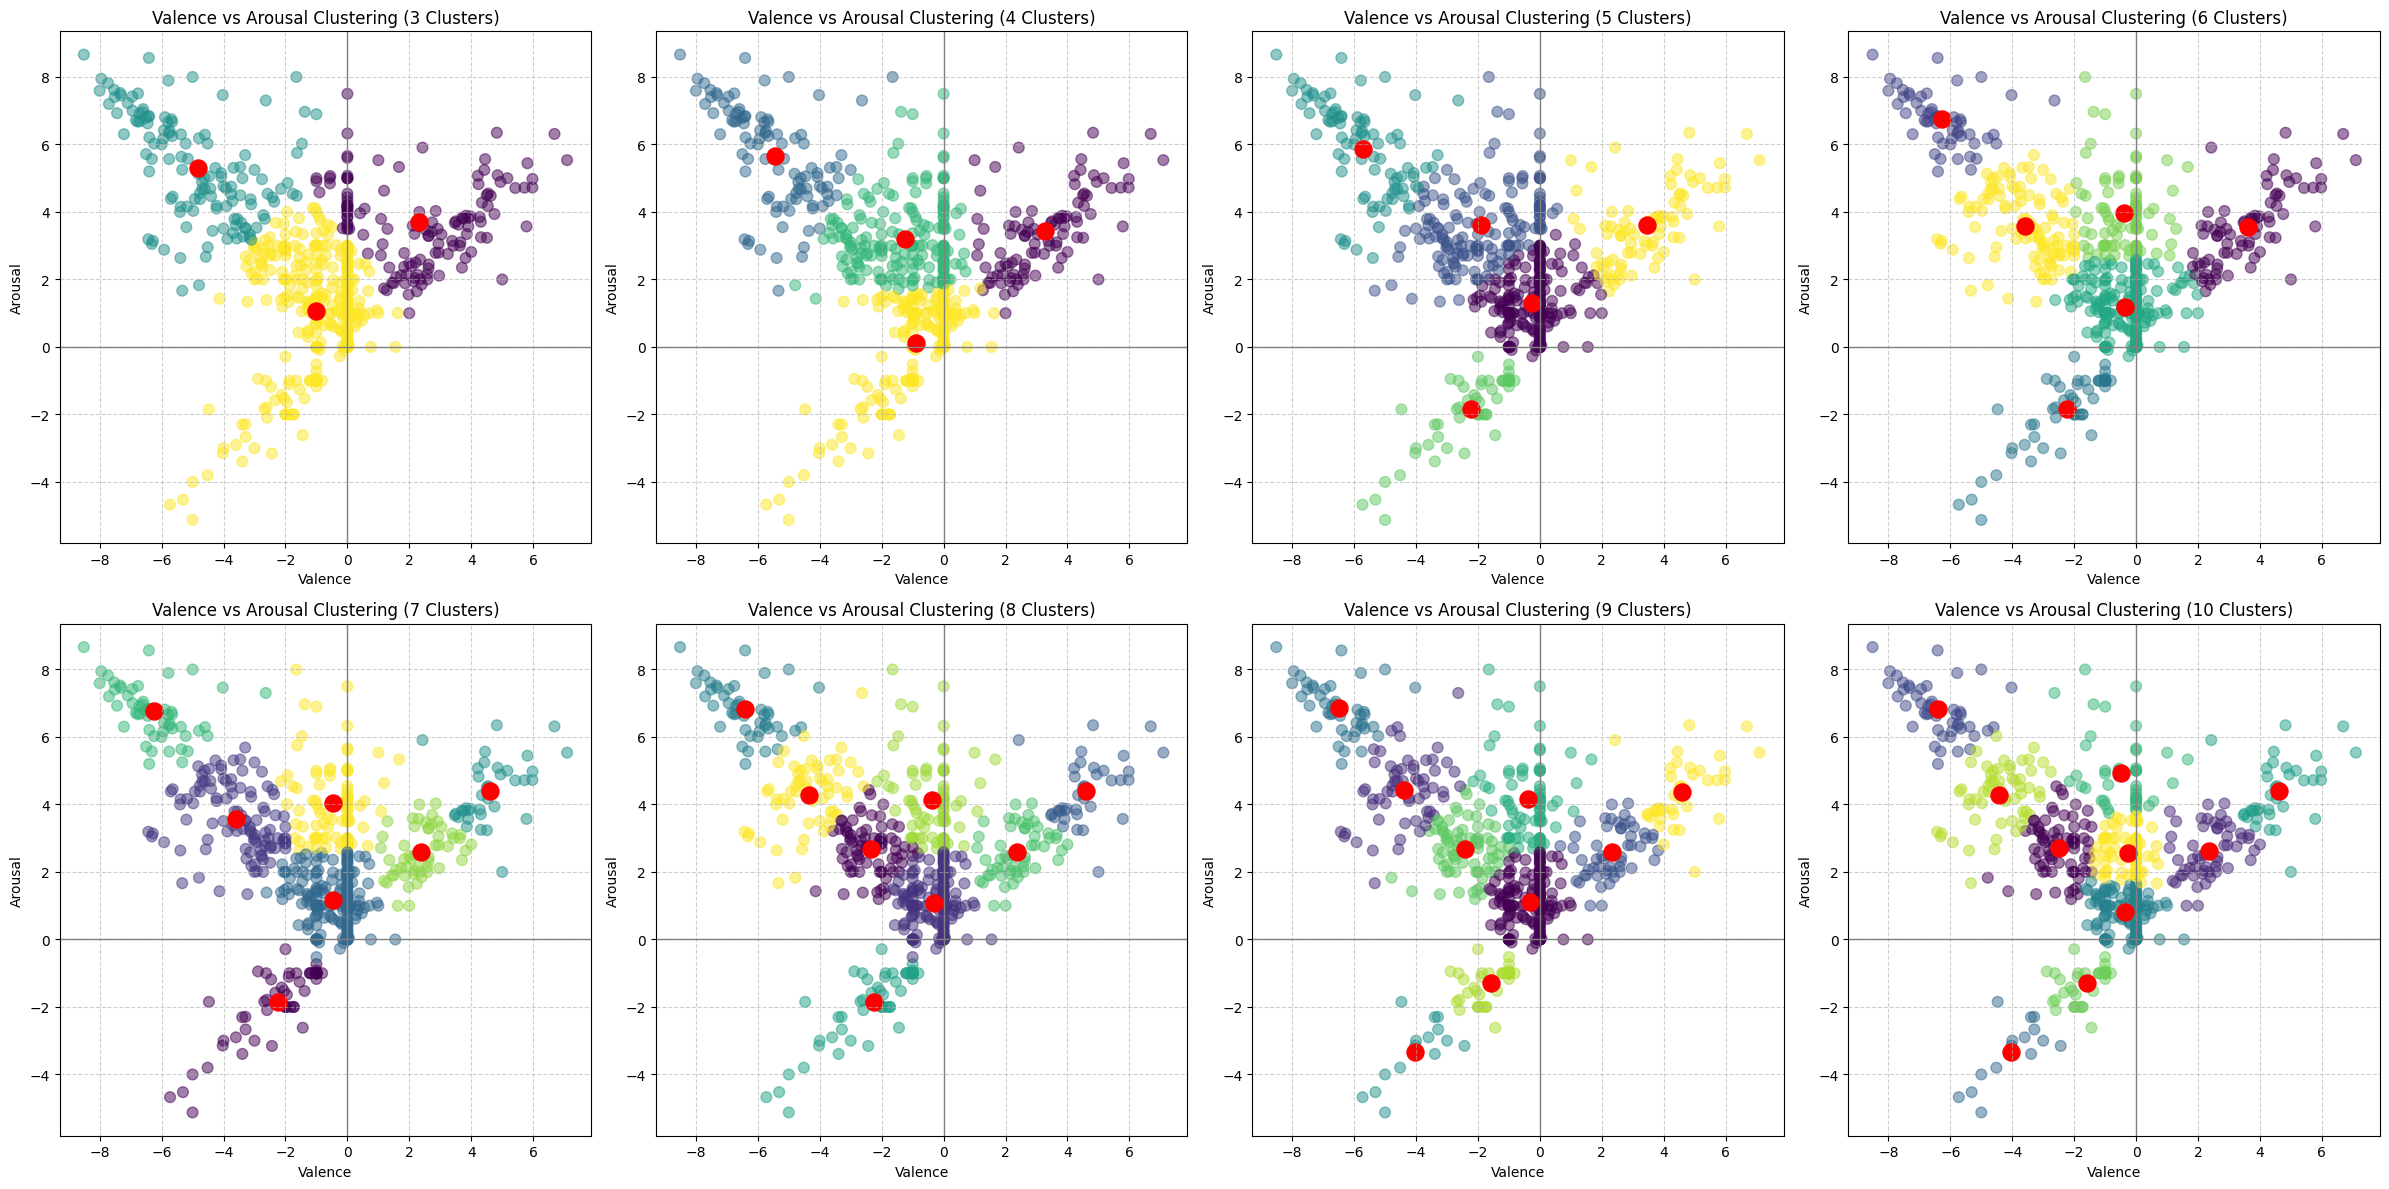

In [14]:
# Perform KMeans clustering on the average valence and arousal data
per_file_data = analysis_results.get("per_file_average", {})
X = np.array([[data['average_valence'], data['average_arousal']] for data in per_file_data.values()])


fig, axes = plt.subplots(2, 4, figsize=(24, 12))
axes = axes.flatten()
cluster_range = range(3, 11) # Number of clusters to test

for i, num_clusters in enumerate(cluster_range):
    labels, centers = kmeans_clustering(X, num_clusters)
    
    ax = axes[i]
    scatter = ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.5, s=60)
    ax.scatter(centers[:, 0], centers[:, 1], c='red', s=150, marker='o', label='Centroids')

    ax.set_title(f'Valence vs Arousal Clustering ({num_clusters} Clusters)')
    ax.set_xlabel('Valence')
    ax.set_ylabel('Arousal')

    ax.grid(True, linestyle='--', alpha=0.6)
    ax.axhline(0, color='grey', lw=1)
    ax.axvline(0, color='grey', lw=1)

    ax.legend

plt.tight_layout()
plt.show()

#### 🔎 Determining the Optimal Number of Clusters

To transform the continuous valence-arousal data into discrete emotion classes, we first need to determine the most natural number of emotion groups present in the dataset. The plots above show the result of running the K-Means clustering algorithm with a range of different cluster counts (`k`), from 3 to 10.

By visually inspecting these results, we can find the "sweet spot" that best represents distinct, meaningful emotional categories.

**Why 5 Clusters is the Sweet Spot**

* **When `k` is too low (e.g., 3 or 4):** The clustering is **too general**. It groups together emotions that are clearly distinct. For example, in the `k=3` plot, all high-arousal emotions (like 'Happy', 'Anger', and 'Shock') are forced into just two groups, losing valuable nuance.

* **When `k` is too high (e.g., 6 to 10):** The algorithm starts to **overfit** the data. It begins partitioning the large, natural emotional clouds into smaller, less meaningful sub-regions that don't correspond to a clear, single emotional state.

* **When `k=5`:** This configuration provides the best balance. It successfully identifies the five most prominent and well-separated emotional groups that align with our intuitive understanding of emotion:
    1.  A high-arousal, positive-valence group (**Happy**).
    2.  A high-arousal, negative-valence group (**Anger**).
    3.  A high-arousal, neutral-valence group (**Shock**).
    4.  A low-arousal, negative-valence group (**Sad**).
    5.  A low-arousal, mid-valence group (**Neutral**).

Therefore, **k=5** is chosen as the optimal number of clusters. This allows us to create a rich yet manageable set of emotion labels for training our final classification model.

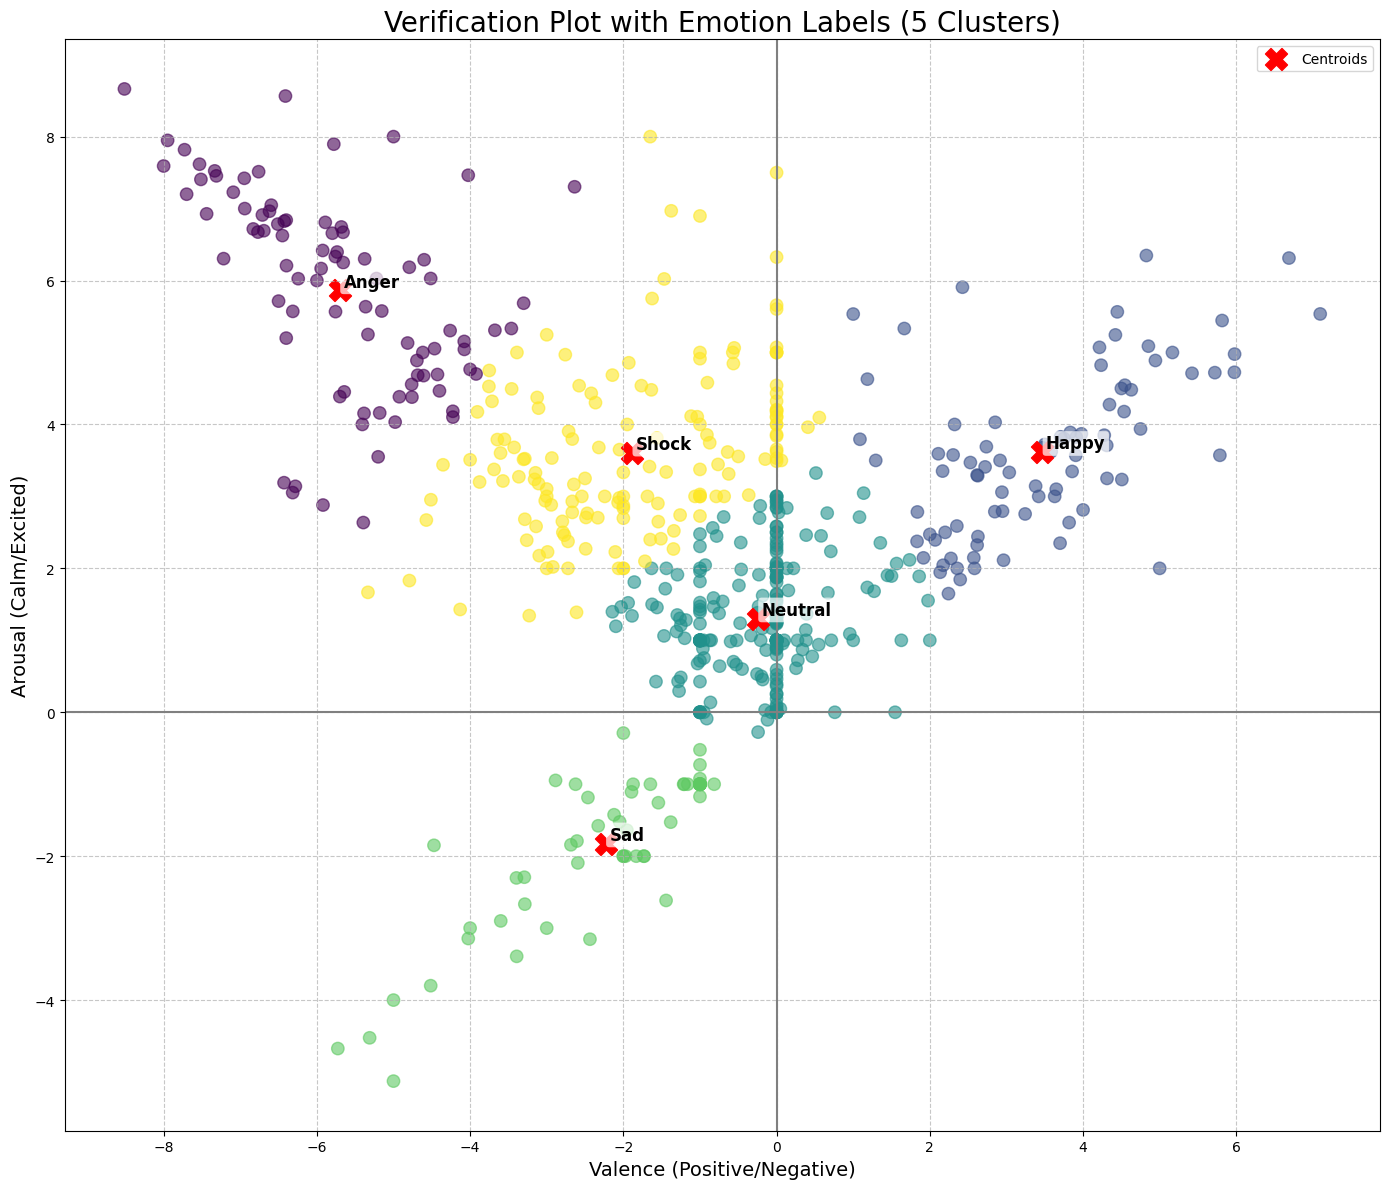

In [15]:
# Choose the number of best clusters for KMeans
choosen_k = 5
# Emotion labels for the clusters
emotion_labels = [
    'Anger',
    'Happy',
    'Shock',
    'Neutral',
    'Sad'
]

# Write labels to JSON file with KMeans clustering results
labeled_data, centers = write_labels(
    base_folder,
    choosen_k,
    emotion_labels,
    output_filename='./Data/AFEW-VA/labeled_emotions.json'
)

# Prepare data for plotting from the returned dictionary
X = np.array([[data['average_valence'], data['average_arousal']] for data in labeled_data.values()])

# Create a numeric label for each point for coloring the plot
unique_labels = sorted(list(set(emotion_labels)))
label_to_color_index = {label: i for i, label in enumerate(unique_labels)}
plot_colors = [label_to_color_index[data['emotion_label']] for data in labeled_data.values()]

# Create the verification plot
plt.figure(figsize=(14, 12))
plt.scatter(X[:, 0], X[:, 1], c=plot_colors, cmap='viridis', alpha=0.6, s=80)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=250, marker='X', label='Centroids')

# Annotate each centroid with its assigned emotion label
sorted_centroid_indices = sorted(range(choosen_k), key=lambda k: (-centers[k][1], centers[k][0]))
for i, original_index in enumerate(sorted_centroid_indices):
    center_coords = centers[original_index]
    label_text = emotion_labels[i]
    
    plt.text(
        center_coords[0] + 0.05, center_coords[1] + 0.05, label_text, 
        fontsize=12, 
        fontweight='bold',
        color='black',
        bbox=dict(
            facecolor='white', 
            alpha=0.7, 
            edgecolor='none', 
            boxstyle='round,pad=0.2'
        )
    )

plt.title(f'Verification Plot with Emotion Labels ({choosen_k} Clusters)', fontsize=20)
plt.xlabel('Valence (Positive/Negative)', fontsize=14)
plt.ylabel('Arousal (Calm/Excited)', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(0, color='grey', lw=1.5)
plt.axvline(0, color='grey', lw=1.5)

plt.legend()
plt.tight_layout()
plt.show()

#### ✅ Final Label Verification

This verification plot shows the final result of our data labeling process. After confirming that 5 clusters provide the best separation, a specific emotion label has been assigned to each cluster. Each data point (representing a video) is now colored according to its final assigned emotion, and the cluster centers (centroids) are marked with a red 'X'.

The emotion labels were assigned logically based on each centroid's position within the two-dimensional emotional space:

* **Anger**: Located in the high-arousal, negative-valence quadrant.
* **Happy**: Located in the high-arousal, positive-valence quadrant.
* **Shock**: Positioned in the high-arousal, near-neutral valence area, representing a state of surprise.
* **Sad**: Found in the low-arousal, negative-valence quadrant.
* **Neutral**: Positioned near the origin, representing a state of low arousal and neutral valence.

This plot visually confirms that our pipeline has successfully transformed the raw, continuous valence-arousal data into a well-defined and intuitively correct set of five discrete emotion categories. With this labeled and verified dataset, we are now ready to proceed to the feature extraction stage.

In [16]:
move_video_to_labeled_folders(
    './Data/AFEW-VA/labeled_emotions.json',
    video_output_folder,
    video_output_folder
)

move_videos_by_correction(
    video_output_folder,
    './label_correction.csv'
)

#### Manual Label Correction ✍️

While K-Means provides an excellent starting point, automated clustering may not perfectly capture the nuances of human emotion in every case. To ensure the highest quality training data, a manual review and correction step is performed.

A `label_correction.csv` file is used to document any necessary changes. This file specifies which videos should be moved from their `initial_label` (assigned by the clustering algorithm) to a more accurate `corrected_label` based on visual inspection. Below is an example of how this file is structured:

| file_name | initial_label | corrected_label |
|:----------|:--------------|:----------------|
| `021.mp4` | Anger         | Shock           |
| `113.mp4` | Anger         | Shock           |
| `120.mp4` | Anger         | Sad             |

The final step in our labeling process involves running a script that reads this CSV and moves the corresponding video files between folders, solidifying our ground-truth dataset before feature extraction begins.

C:\Users\MUHAMMADRAFLYARJASUB\AppData\Local\Temp\ipykernel_4152\4058888927.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=totals, y=emotions, orient='h', palette='viridis', ax=axes[1])


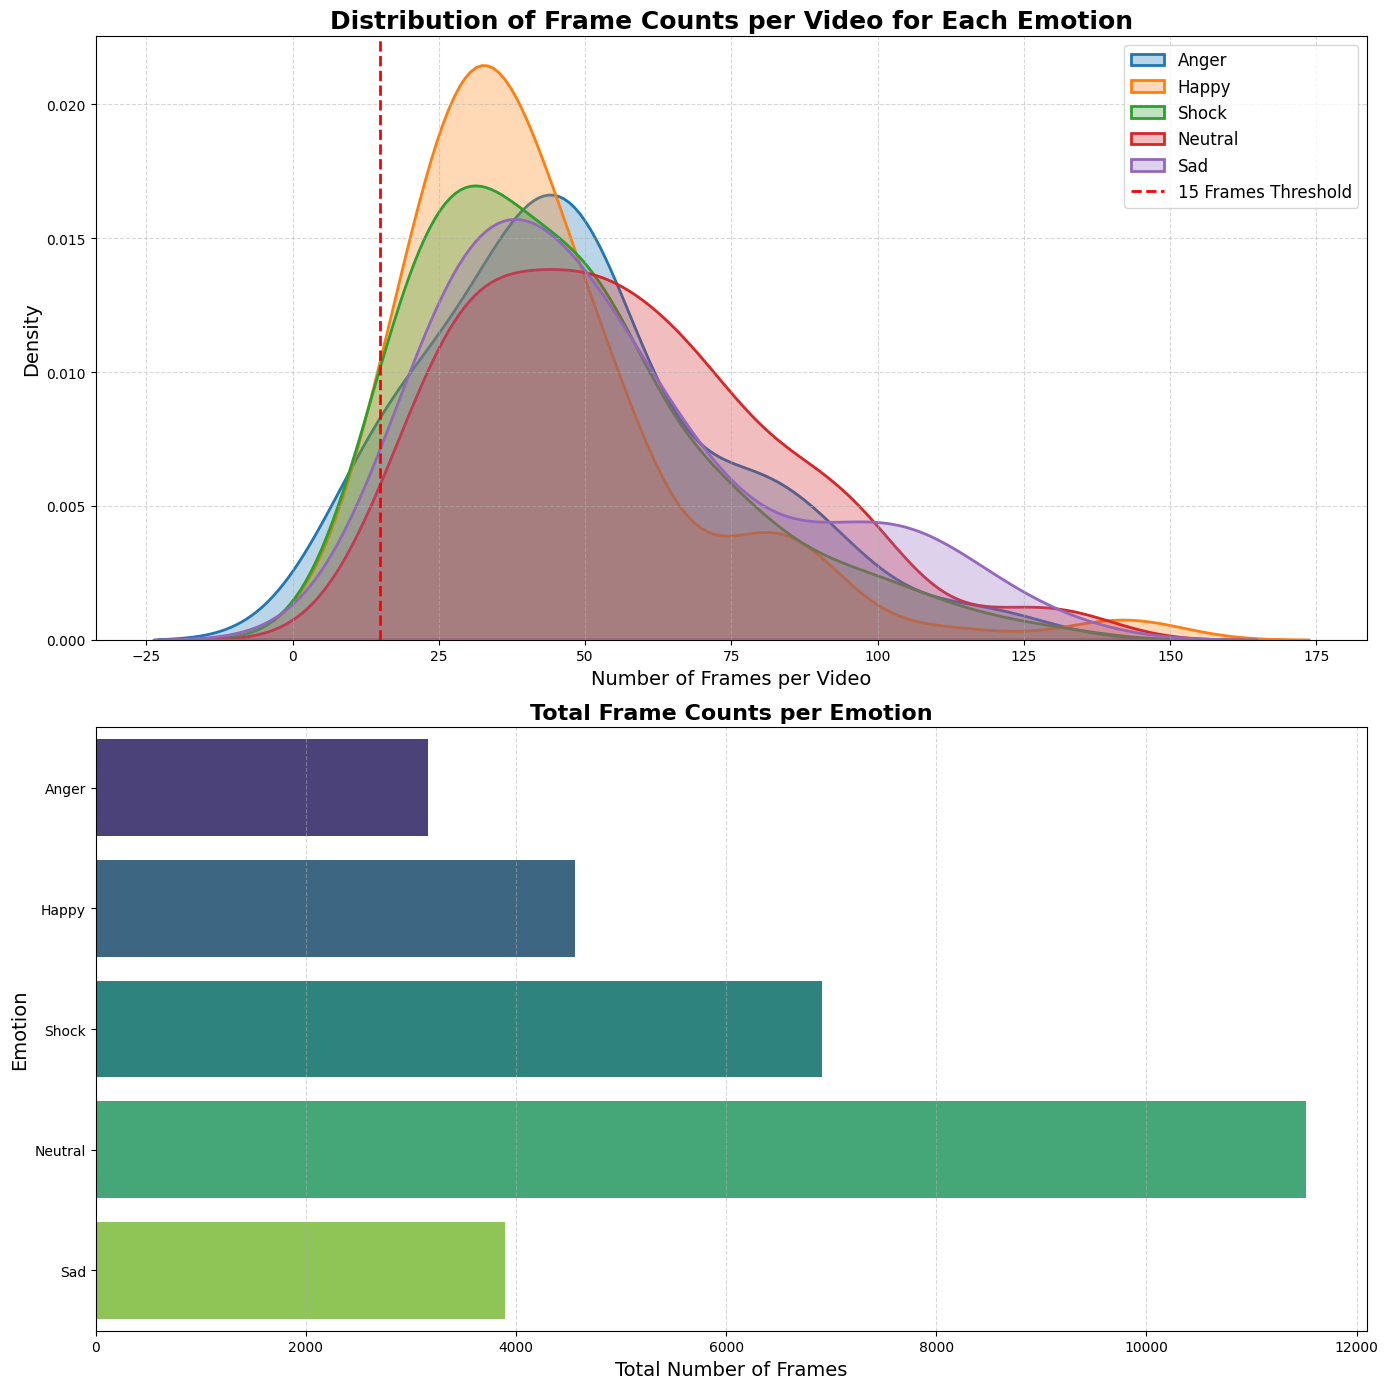

In [17]:
frame_counts, total_frame_counts = get_frame_counts(video_output_folder, emotion_labels)

fig, axes = plt.subplots(2, 1, figsize=(14, 14))

# KDE plot for frame count distribution
for emotion, counts in frame_counts.items():
    sns.kdeplot(counts, label=emotion, fill=True, alpha=0.3, linewidth=2, ax=axes[0])
axes[0].axvline(x=15, color='red', linestyle='--', linewidth=2, label='15 Frames Threshold')
axes[0].set_xlabel('Number of Frames per Video', fontsize=14)
axes[0].set_ylabel('Density', fontsize=14)
axes[0].set_title('Distribution of Frame Counts per Video for Each Emotion', fontsize=18, fontweight='bold')
axes[0].legend(fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.5)

# Bar plot for total frame counts per emotion
emotions = list(total_frame_counts.keys())
totals = [total_frame_counts[emotion] for emotion in emotions]
sns.barplot(x=totals, y=emotions, orient='h', palette='viridis', ax=axes[1])
axes[1].set_xlabel('Total Number of Frames', fontsize=14)
axes[1].set_ylabel('Emotion', fontsize=14)
axes[1].set_title('Total Frame Counts per Emotion', fontsize=16, fontweight='bold')
axes[1].grid(True, axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
        

#### 📊 Analyzing Data Distribution and Class Balance

Before building the model, it's essential to understand the characteristics of our processed dataset. The plots below examine the distribution of video lengths and the balance between our five emotion classes.

**Distribution of Video Lengths**

The top plot shows the distribution of video lengths (in frames) for each of the five emotion categories. We can see that most videos are between 25 and 75 frames long.

The red dashed line marks the **15 Frames Threshold**. This is a critical parameter because our CNN-LSTM model is designed to process sequences of a fixed length (15 frames). This threshold was chosen as a strategic balance:
* It is short enough that the vast majority of videos in the dataset can provide at least one complete 15-frame data sample, maximizing the amount of usable data.
* It is long enough to capture meaningful temporal changes in a facial expression, which is crucial for the LSTM component of our model.

**Total Frame Counts and Class Imbalance**

The bottom bar chart reveals the total number of frames available for each emotion class. This plot highlights a very important characteristic of the dataset: **class imbalance**.

As shown, the 'Neutral' class has significantly more data (over 12,000 frames) than any other class, while 'Anger' has the least (around 3,000 frames). This imbalance is a key challenge that must be considered during the modeling phase, as it can cause the model to become biased towards predicting the majority classes.

### 📜 Stage 3: Face Mesh Extraction to Sequential CSVs

This final preprocessing stage converts the labeled videos into a numerical format suitable for our CNN-LSTM model. For each video, this script:
1.  **Extracts Landmarks**: Uses Google's MediaPipe Face Mesh to detect and extract the 3D coordinates (x, y, z) for 468 facial landmarks from every frame. To handle frames where a face is not detected, the landmarks from the previously successful frame are repeated.
2.  **Chunks Data**: To prepare the data for a sequence model, the landmark data is chunked into sequences of **15 frames**.
3.  **Exports to CSV**: Each 15-frame chunk is saved as a separate `.csv` file. If the last chunk of a video has between 10 and 14 frames, it is padded to 15 frames to ensure sequence consistency. This results in a dataset of thousands of CSV files, each representing a short, sequential facial expression.

In [18]:
def export_video_to_csv(video_path, csv_dir):
    """
    Extract face mesh landmarks from video and export to CSV files in chunks.
    Each CSV contains up to 15 frames (padded if last chunk < 15 but >= 10).
    """
    mp_face_mesh = mp.solutions.face_mesh

    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames < 10:
        print(f"Video {video_path} has less than 10 frames: {total_frames}")

    frame_idx = 0
    chunk_idx = 1
    chunk = []
    last_row = None

    # Prepare CSV header
    header = ['frame']
    for i in range(468):
        header.extend([f'x_{i}', f'y_{i}', f'z_{i}'])

    base_filename = os.path.splitext(os.path.basename(video_path))[0]

    with mp_face_mesh.FaceMesh(
        static_image_mode=False,
        max_num_faces=1,
        refine_landmarks=False,
        min_detection_confidence=0.35,
        min_tracking_confidence=0.35
    ) as face_mesh:

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = face_mesh.process(rgb_frame)

            if results.multi_face_landmarks:
                for face_landmarks in results.multi_face_landmarks:
                    row = [frame_idx]
                    for landmark in face_landmarks.landmark:
                        row.extend([landmark.x, landmark.y, landmark.z])
                    last_row = row
            else:
                # If no face detected, repeate last row
                if last_row is not None:
                    row = [frame_idx] + last_row[1:]
                else: # Case for first frame with no face detected
                    row = [frame_idx] + [0] * (468 * 3)

            chunk.append(row)
            frame_idx += 1

            # Write chunk to CSV if it reaches 15 frames
            if len(chunk) == 15:
                csv_filename = f"{base_filename}_{chunk_idx:03d}.csv"
                csv_path = os.path.join(csv_dir, csv_filename)
                with open(csv_path, 'w', newline='') as csv_file:
                    writer = csv.writer(csv_file)
                    writer.writerow(header)
                    writer.writerows(chunk)
                chunk_idx += 1
                chunk = []

        # If last chunk has 10 <= frame < 15, pad to 15 and save
        if 10 <= len(chunk) < 15:
            while len(chunk) < 15:
                chunk.append(chunk[-1][:])
            csv_filename = f"{base_filename}_{chunk_idx:03d}.csv"
            csv_path = os.path.join(csv_dir, csv_filename)
            with open(csv_path, 'w', newline='') as csv_file:
                writer = csv.writer(csv_file)
                writer.writerow(header)
                writer.writerows(chunk)

    cap.release()

In [19]:
def process_video_to_csv(args):
    emotion, video_file = args
    
    emotion_folder = os.path.join(video_output_folder, emotion)
    facemesh_emotion_folder = os.path.join(facemesh_output_folder, emotion)
    
    os.makedirs(facemesh_emotion_folder, exist_ok=True)
    video_path = os.path.join(emotion_folder, video_file)
        
    export_video_to_csv(video_path, facemesh_emotion_folder)

# Collect all video tasks for processing
video_tasks = []
for emotion in os.listdir(video_output_folder):
    emotion_folder = os.path.join(video_output_folder, emotion)

    for video_file in os.listdir(emotion_folder):
        video_tasks.append((emotion, video_file))
            
with ThreadPoolExecutor(max_workers=os.cpu_count() * 2) as executor:
    list(tqdm.tqdm(executor.map(process_video_to_csv, video_tasks), total=len(video_tasks), desc='Exporting FaceMesh CSV'))

Exporting FaceMesh CSV: 100%|██████████| 600/600 [01:15<00:00,  7.99it/s]


## 🧠 3. Modeling

With the data processed and structured into sequential CSV files, we can now build and train our deep learning model. This section covers the entire modeling pipeline using **PyTorch**, from loading the data to evaluating the final model's performance.

The modeling process is broken down into the following key steps:

1.  **Data Loading & Preparation**:
    * A custom PyTorch `Dataset` class (`FacemeshDataset`) is created to efficiently load the thousands of CSV files in parallel.
    * The dataset is split into a **training set** and a **validation set**. A `stratified` split is used to ensure that the class imbalance observed during our data analysis is preserved in both sets, leading to more reliable validation.
    * PyTorch `DataLoaders` are used to handle batching and shuffling of the data during training.

2.  **Model Architecture: The CNN-LSTM**:
    A hybrid **Convolutional Neural Network (CNN) and Long Short-Term Memory (LSTM)** model is designed to effectively learn from the spatio-temporal facial landmark data.
    * 🧠 **1D CNN Layers**: The model first uses 1D convolutional layers to act as a powerful feature extractor. These layers identify complex **spatial patterns** among the 468 facial landmarks within each time step of the 15-frame sequence.
    * 🧠 **Bidirectional LSTM Layers**: The features extracted by the CNN are then fed into a bidirectional LSTM. The LSTM's strength is in learning **temporal patterns**—it analyzes how the facial landmarks evolve over the 15-frame sequence. Using a *bidirectional* LSTM allows the model to learn from the sequence in both forward and reverse directions, capturing a more complete context of the expression.
    * 🧠 **Classifier Head**: Finally, a set of fully connected layers act as the classifier, taking the learned features from the LSTM and making the final prediction among the five emotion classes.

3.  **Training & Validation**:
    * The model is trained for 25 epochs using the **Adam optimizer** and **Cross-Entropy Loss** function, which are standard choices for multi-class classification.
    * After each epoch of training, the model's performance is evaluated on the unseen validation set.
    * The model weights are saved after every epoch, and the best-performing model (based on the highest validation accuracy) is specifically saved for final evaluation.

4.  **Evaluation**:
    * After training is complete, the best saved model is loaded.
    * Its performance is thoroughly assessed using multiple metrics: overall accuracy, a detailed **classification report** (with precision, recall, and F1-score for each emotion), and a **confusion matrix** to visualize which emotions the model confuses with each other.

In [20]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor
import time
import csv
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
class FacemeshDataset(Dataset):
    def __init__(self, file_paths, labels, label_map):
        super().__init__()
        self.file_paths = file_paths
        self.str_labels = labels
        self.label_map = label_map
        
        self.data_tensor = []
        self.label_tensor = []
        
        self.idx_to_label = {v: k for k, v in label_map.items()}

        # Load CSV to Tensor
        def _load_file(args):
            file_path, label_str = args
            try:
                df = pd.read_csv(file_path)
                df = df.drop(columns=['frame'], errors='ignore')
                
                data = torch.tensor(df.values, dtype=torch.float32)
                label_int = self.label_map[label_str]
                label = torch.tensor(label_int, dtype=torch.long)
                return data, label
            except Exception as e:
                print(f"Skipping file due to error: {file_path} | Error: {e}")
                return None, None

        # Parallelized Data Loading
        tasks = zip(self.file_paths, self.str_labels)
        with ThreadPoolExecutor(max_workers=os.cpu_count() * 2) as executor:
            results = list(tqdm(executor.map(_load_file, tasks), total=len(self.file_paths), desc="Processing files"))

        for data, label in results:
            if data is not None and label is not None:
                self.data_tensor.append(data)
                self.label_tensor.append(label)


    def __len__(self):
        return len(self.data_tensor)
    
    def __getitem__(self, idx):
        return self.data_tensor[idx], self.label_tensor[idx]



In [22]:
data_dir = './Data/AFEW-VA/FaceMesh'
batch_size = 48 # Change batch size according to VRAM
valid_split = 0.2

In [23]:
# Gather all csv paths and its label
all_files = []
all_labels_str = []
emotion_folders = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
for emotion in emotion_folders:
    emotion_path = os.path.join(data_dir, emotion)
    csv_files = [f for f in os.listdir(emotion_path) if f.endswith('.csv')]
    for csv_file in csv_files:
        full_path = os.path.join(emotion_path, csv_file)
        all_files.append(full_path)
        all_labels_str.append(emotion)

unique_labels = sorted(list(set(all_labels_str)))
label_map = {label: i for i, label in enumerate(unique_labels)}

# Randomly split train & val
train_files, val_files, train_labels_str, val_labels_str = train_test_split(
    all_files, all_labels_str, 
    test_size=valid_split, 
    random_state=42, 
    stratify=all_labels_str
)

# Load dataset
train_dataset = FacemeshDataset(train_files, train_labels_str, label_map)
val_dataset = FacemeshDataset(val_files, val_labels_str, label_map)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

Processing files: 100%|██████████| 385/385 [00:16<00:00, 23.05it/s]


In [24]:
input_size = 1404 # Facemesh have 1404 point
num_classes = len(label_map)

# Train parameters
learning_rate = 0.0001
epochs = 2500 # Adjust if if necessary

In [25]:
class EmotiMesh_Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, 
                 cnn_out_channels, kernel_size, stride, padding,
                 lstm_dropout, classifier_dropout):
        super(EmotiMesh_Net, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.input_bn = nn.BatchNorm1d(input_size)

        # 1D Conv block
        self.conv1 = nn.Conv1d(in_channels=1, 
                               out_channels=cnn_out_channels, 
                               kernel_size=kernel_size,
                               stride=stride,
                               padding=padding)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Calculate output size from CNN
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, input_size)
            cnn_out_length = self.pool1(self.conv1(dummy_input)).shape[2]
        
        self.cnn_output_size = cnn_out_channels * cnn_out_length

        # Bi-LSTM block
        self.lstm = nn.LSTM(input_size=self.cnn_output_size, 
                            hidden_size=hidden_size, 
                            num_layers=num_layers, 
                            batch_first=True, 
                            bidirectional=True,
                            dropout=lstm_dropout if num_layers > 1 else 0)
        
        # Classifier head
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.bn_fc1 = nn.BatchNorm1d(hidden_size)
        self.relu_fc1 = nn.ReLU()
        self.dropout = nn.Dropout(classifier_dropout)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        batch_size, seq_length, _ = x.shape
        x_reshaped = x.view(batch_size * seq_length, -1)
        x_bn = self.input_bn(x_reshaped)
        
        x_cnn_input = x_bn.view(batch_size * seq_length, 1, -1)
        cnn_out = self.pool1(self.relu1(self.conv1(x_cnn_input)))
        
        lstm_input = cnn_out.view(batch_size, seq_length, -1)
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        
        lstm_out, _ = self.lstm(lstm_input, (h0, c0)) 
        last_time_step_output = lstm_out[:, -1, :]
        
        out = self.dropout(self.relu_fc1(self.bn_fc1(self.fc1(last_time_step_output))))
        out = self.fc2(out)
        
        return out

In [26]:
model = EmotiMesh_Net(
    input_size=input_size,
    hidden_size=192,
    num_layers=2,
    num_classes=num_classes, # Make sure this is defined
    cnn_out_channels=128,
    kernel_size=7,
    stride=1,
    padding=2,
    lstm_dropout=0.25,
    classifier_dropout=0.25
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

c:\ProgramData\anaconda3\envs\pytorch\lib\site-packages\torch\cuda\__init__.py:235: UserWarning: 
NVIDIA GeForce RTX 5060 Ti with CUDA capability sm_120 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 sm_80 sm_86 sm_90 compute_37.
If you want to use the NVIDIA GeForce RTX 5060 Ti GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(


EmotiMesh_Net(
  (input_bn): BatchNorm1d(1404, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv1d(1, 128, kernel_size=(7,), stride=(1,), padding=(2,))
  (relu1): ReLU()
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(89728, 192, num_layers=2, batch_first=True, dropout=0.25, bidirectional=True)
  (fc1): Linear(in_features=384, out_features=192, bias=True)
  (bn_fc1): BatchNorm1d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_fc1): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=192, out_features=5, bias=True)
)

In [27]:
# Setup for saving model and logging
SAVE_DIR = "./Models"
os.makedirs(SAVE_DIR, exist_ok=True)
best_val_loss = float('inf')
best_val_acc = 0.0

log_file_path = os.path.join(SAVE_DIR, 'model_logs.csv')
log_header = ['epoch', 'time_seconds', 'train_acc', 'train_loss', 'val_acc', 'val_loss', 'learning_rate']
with open(log_file_path, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(log_header)

In [ ]:
# Training loop
start_time = time.time()
for epoch in range(epochs):
    # Training Phase
    model.train()
    running_loss_train = 0.0
    correct_predictions_train = 0
    
    for sequences, labels in train_loader:
        sequences, labels = sequences.to(device), labels.to(device)
        
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate train metrics
        running_loss_train += loss.item() * sequences.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct_predictions_train += (predicted == labels).sum().item()

    epoch_loss_train = running_loss_train / len(train_loader.dataset)
    epoch_acc_train = correct_predictions_train / len(train_loader.dataset)

    # Validation Phase
    model.eval()
    running_loss_val = 0.0
    correct_predictions_val = 0

    with torch.no_grad():
        for sequences, labels in val_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            
            # Accumulate validation metrics
            running_loss_val += loss.item() * sequences.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct_predictions_val += (predicted == labels).sum().item()

    epoch_loss_val = running_loss_val / len(val_loader.dataset)
    epoch_acc_val = correct_predictions_val / len(val_loader.dataset)
    
    current_lr = scheduler.get_last_lr()[0]
    
    # Print Epoch Results
    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {epoch_loss_train:.4f}, Train Acc: {epoch_acc_train:.4f} | "
          f"Val Loss: {epoch_loss_val:.4f}, Val Acc: {epoch_acc_val:.4f} | "
          f"LR: {current_lr:.6f}") 
    
    
    # Save the last model
    torch.save(model.state_dict(), os.path.join(SAVE_DIR, 'last_model.pth'))

    # Save the model with the best validation loss
    if epoch_loss_val < best_val_loss:
        best_val_loss = epoch_loss_val
        torch.save(model.state_dict(), os.path.join(SAVE_DIR, 'best_val_loss_model.pth'))
        print(f"✅ New best validation loss model saved: {best_val_loss:.4f}")

    # Save the model with the best validation accuracy
    if epoch_acc_val > best_val_acc:
        best_val_acc = epoch_acc_val
        torch.save(model.state_dict(), os.path.join(SAVE_DIR, 'best_val_acc_model.pth'))
        print(f"✅ New best validation accuracy model saved: {best_val_acc:.4f}")
        
    print('-' * 50)
    
    # Logging to csv
    elapsed_time = time.time() - start_time
    log_data = [epoch + 1, elapsed_time, epoch_acc_train, epoch_loss_train, epoch_acc_val, epoch_loss_val, current_lr]
    with open(log_file_path, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(log_data)
    
    scheduler.step()


## 📈 4. Model Evaluation & Results

After training, the best-performing model is loaded and evaluated on the unseen validation set. The model achieves a strong **overall accuracy of 79.74%**, indicating that it can correctly classify the emotion in videos approximately 4 out of 5 times.

A more detailed breakdown of its performance on each emotion class reveals specific strengths and areas for improvement.

In [28]:
# Load best model
best_model_path = os.path.join('./Models', 'best_val_loss_model.pth')

# Load architecture
model = EmotiMesh_Net(
    input_size=input_size,
    hidden_size=192,
    num_layers=2,
    num_classes=num_classes,
    cnn_out_channels=128,
    kernel_size=7,
    stride=1,
    padding=2,
    lstm_dropout=0.25,
    classifier_dropout=0.25
)
# Load weight
model.load_state_dict(torch.load(best_model_path, map_location=device))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

EmotiMesh_Net(
  (input_bn): BatchNorm1d(1404, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv1d(1, 128, kernel_size=(7,), stride=(1,), padding=(2,))
  (relu1): ReLU()
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(89728, 192, num_layers=2, batch_first=True, dropout=0.25, bidirectional=True)
  (fc1): Linear(in_features=384, out_features=192, bias=True)
  (bn_fc1): BatchNorm1d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_fc1): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=192, out_features=5, bias=True)
)

In [29]:
all_preds = []
all_labels = []

torch.cuda.synchronize()
# Evaluate model on val dataset
with torch.no_grad():
    for sequences, labels in tqdm(val_loader, desc="Evaluating Model"):
        sequences, labels = sequences.to(device), labels.to(device)
        
        outputs = model(sequences)
        _, predicted = torch.max(outputs.data, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Evaluating Model: 100%|██████████| 9/9 [00:01<00:00,  6.03it/s]


In [37]:
accuracy = accuracy_score(all_labels, all_preds)
class_names = [val_dataset.idx_to_label[i] for i in range(num_classes)]
report = classification_report(all_labels, all_preds, target_names=class_names)

print(f"Overall Model Accuracy: {(round(accuracy, 4))*100}%")
print("Classification Report:\n")
print(report)

Overall Model Accuracy: 79.74%
Classification Report:

              precision    recall  f1-score   support

       Anger       0.83      0.75      0.79        40
       Happy       0.80      0.67      0.73        58
     Neutral       0.78      0.93      0.84       149
         Sad       0.92      0.73      0.82        49
       Shock       0.77      0.72      0.74        89

    accuracy                           0.80       385
   macro avg       0.82      0.76      0.78       385
weighted avg       0.80      0.80      0.79       385



After training, the best-performing model is loaded and evaluated on the unseen validation set. The model achieves a strong **overall accuracy of 79.74%**, indicating that it can correctly classify the emotion in videos approximately 4 out of 5 times.

A more detailed breakdown of its performance on each emotion class reveals specific strengths and areas for improvement.

### ✅ Strengths

* **Excellent Recall for 'Neutral'**: The model is exceptionally good at identifying `Neutral` expressions, correctly finding 93% of all neutral samples in the dataset. This high recall is likely supported by 'Neutral' being the majority class with 149 samples.
* **High Precision for 'Sad'**: When the model predicts an emotion is `Sad`, it is highly reliable, being correct 92% of the time. This suggests a low rate of false positives for this class.
* **Robust Performance on Minority Class**: Despite `Anger` having the fewest samples in the validation set (support: 40), the model performs well on it, achieving a balanced F1-score of 0.79.

### ⚠️ Weaknesses & Areas for Improvement

* **Difficulty Recognizing 'Happy'**: The model's most significant weakness is in identifying `Happy` expressions. It only manages to recall 67% of the true happy samples, meaning it misses about one-third of them. These may be misclassified as other emotions like 'Neutral' or 'Shock'.
* **Lower Performance on 'Shock'**: The 'Shock' category also shows room for improvement, with a lower F1-score of 0.74 compared to other classes like 'Neutral' (0.84) and 'Sad' (0.82).
* **Influence of Class Imbalance**: The model's strong performance on the `Neutral` class might be partially influenced by it having significantly more training data than any other emotion.

In summary, the model shows strong promise with good overall performance. The primary area for future work would be to improve the recognition of `Happy` expressions, possibly by gathering more diverse training examples for that class or by fine-tuning the model further.

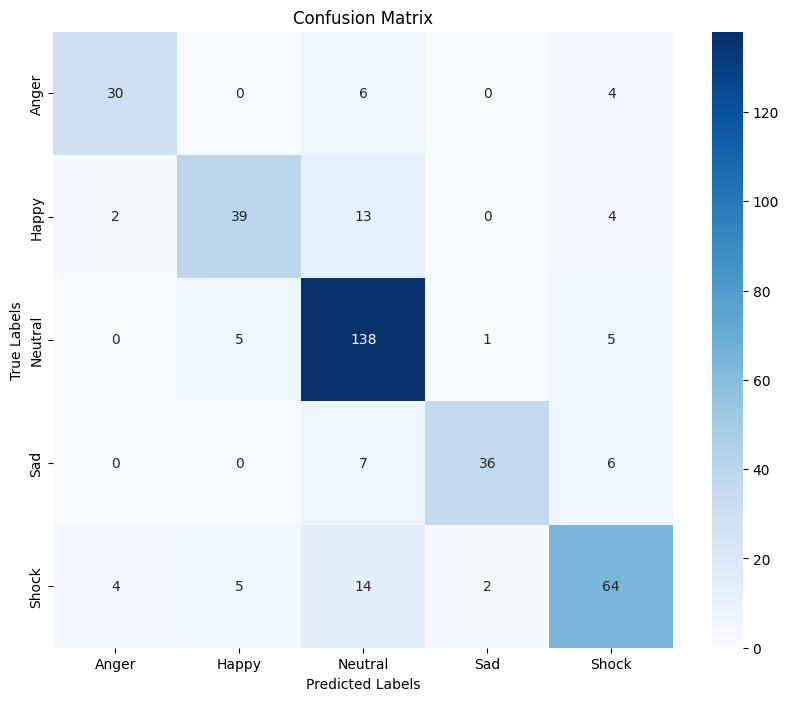

In [32]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

* 🔎 **Visual Deep-Dive**: The confusion matrix offers a detailed analysis of the model's predictions, showing exactly where it succeeds and where it makes errors.

* 🧠 **The 'Neutral' Gravity Well**: The model's most notable pattern is a strong tendency to misclassify other emotions as `Neutral`. This is its most common type of error, likely influenced by the class imbalance in the dataset.

* 📉 **Key Misclassifications**: The most significant errors involve videos being mislabeled as `Neutral`, including 13 `Happy` instances and 14 `Shock` instances.

* ↔️ **High-Arousal Confusion**: The model sometimes confuses emotions with similar high-energy expressions, for example, misclassifying 4 `Anger` videos as `Shock` and 4 `Shock` videos as `Anger`.

* ✅ **Overall Insight**: The matrix confirms that while the model is generally effective, its primary challenges are overcoming the bias towards the majority `Neutral` class and better distinguishing between emotions with overlapping high-arousal characteristics.

## 🏁 Project Conclusion & Future Work

This project successfully developed a complete, end-to-end pipeline for video-based emotion recognition. Starting from a dataset with continuous emotional scores, we engineered a novel labeling process, extracted advanced spatial-temporal features, and trained a robust deep learning model, achieving a strong final performance. The entire workflow demonstrates a viable and effective approach to tackling complex, real-world emotion classification tasks.

### ✨ Key Achievements

* **Novel Data Processing Pipeline**: Successfully created a workflow to address the primary challenge of the AFEW-VA dataset, which lacks discrete emotion labels. This was achieved by:
    * Averaging the raw `valence` and `arousal` scores for each video.
    * Applying K-Means clustering to group videos into natural emotional categories.
    * Performing manual curation to refine the labels, resulting in five distinct classes: `Anger`, `Happy`, `Shock`, `Neutral`, and `Sad`.

* **Hybrid CNN-LSTM Model**: Implemented a powerful `EmotiMesh-Net` architecture in PyTorch.
    * The model leverages **MediaPipe** to extract 468 3D facial landmarks as input features.
    * A **1D-CNN** first extracts spatial patterns from the landmark data within each frame.
    * A **bidirectional LSTM** then analyzes the temporal evolution of these patterns across 15-frame sequences.

* **Strong Final Performance**: The trained model achieved a final **validation accuracy of 79.74%**, proving the effectiveness of the overall approach.

### 🧠 Key Learnings & Insights

* **Model Strengths**: The evaluation revealed that the model is particularly effective at recognizing certain emotions.
    * It has excellent recall for the `Neutral` class, correctly identifying 93% of all neutral samples.
    * It is highly precise when predicting `Sad`, being correct 92% of the time.

* **Model Weaknesses**: The analysis also highlighted clear areas for improvement.
    * The model's biggest challenge is recognizing `Happy` expressions, failing to identify about one-third of the happy samples (67% recall).
    * The confusion matrix shows a strong bias towards the majority `Neutral` class, where other emotions are frequently misclassified. This is a direct result of the **class imbalance** in the dataset.

### 🚀 Future Work

Based on the results, the following steps could be taken to further improve the model:

* **Address Class Imbalance**: Implement techniques like oversampling the minority classes (e.g., `Anger`, `Sad`) or using a weighted loss function during training to give more importance to under-represented emotions.
* **Improve 'Happy' Recognition**: Augment the dataset with more diverse examples of `Happy` expressions or explore feature engineering techniques that better capture the subtle cues of a genuine smile.
* **Architectural Enhancements**: Experiment with adding an **Attention mechanism** to the LSTM. This could help the model focus on the most emotionally expressive frames within a 15-frame sequence, potentially improving accuracy on nuanced expressions.
* **Deployment**: Package the final model into an API and integrate it into the front-end of the conceptual journaling application to complete the project's vision.